# Libreries

In [124]:
%pip install seaborn scikit-learn plotly xgboost prettytable

import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from prettytable import PrettyTable
%matplotlib inline

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


# Load DataSet

In [125]:
pathAndFileName = '../data/smoking.csv'
# Load the dataset
data = pd.read_csv(pathAndFileName)
df = data.copy()
df.head(n = 10).style.background_gradient(cmap = "Greens") 


,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.300000,1.200000,1.000000,1.000000,1.000000,114.000000,73.000000,94.000000,215.000000,82.000000,73.000000,126.000000,12.900000,1.000000,0.700000,18.000000,19.000000,27.000000,Y,0,Y,0
1,1,F,40,160,60,81.000000,0.800000,0.600000,1.000000,1.000000,119.000000,70.000000,130.000000,192.000000,115.000000,42.000000,127.000000,12.700000,1.000000,0.600000,22.000000,19.000000,18.000000,Y,0,Y,0
2,2,M,55,170,60,80.000000,0.800000,0.800000,1.000000,1.000000,138.000000,86.000000,89.000000,242.000000,182.000000,55.000000,151.000000,15.800000,1.000000,1.000000,21.000000,16.000000,22.000000,Y,0,N,1
3,3,M,40,165,70,88.000000,1.500000,1.500000,1.000000,1.000000,100.000000,60.000000,96.000000,322.000000,254.000000,45.000000,226.000000,14.700000,1.000000,1.000000,19.000000,26.000000,18.000000,Y,0,Y,0
4,4,F,40,155,60,86.000000,1.000000,1.000000,1.000000,1.000000,120.000000,74.000000,80.000000,184.000000,74.000000,62.000000,107.000000,12.500000,1.000000,0.600000,16.000000,14.000000,22.000000,Y,0,N,0
5,5,M,30,180,75,85.000000,1.200000,1.200000,1.000000,1.000000,128.000000,76.000000,95.000000,217.000000,199.000000,48.000000,129.000000,16.200000,1.000000,1.200000,18.000000,27.000000,33.000000,Y,0,Y,0
6,6,M,40,160,60,85.500000,1.000000,1.000000,1.000000,1.000000,116.000000,82.000000,94.000000,226.000000,68.000000,55.000000,157.000000,17.000000,1.000000,0.700000,21.000000,27.000000,39.000000,Y,1,Y,1
7,7,M,45,165,90,96.000000,1.200000,1.000000,1.000000,1.000000,153.000000,96.000000,158.000000,222.000000,269.000000,34.000000,134.000000,15.000000,1.000000,1.300000,38.000000,71.000000,111.000000,Y,0,Y,0
8,9,F,50,150,60,85.000000,0.700000,0.800000,1.000000,1.000000,115.000000,74.000000,86.000000,210.000000,66.000000,48.000000,149.000000,13.700000,1.000000,0.800000,31.000000,31.000000,14.000000,Y,0,N,0
9,10,M,45,175,75,89.000000,1.000000,1.000000,1.000000,1.000000,113.000000,64.000000,94.000000,198.000000,147.000000,43.000000,126.000000,16.000000,1.000000,0.800000,26.000000,24.000000,63.000000,Y,0,N,0


In [126]:
TRAIN_FILE = 'train'
TEST_FILE = 'test'
PATH_DATA = '../data/'
EXTENSION_FILE = '.csv'

comp_data_df_train = pd.read_csv(PATH_DATA + TRAIN_FILE + EXTENSION_FILE)
df_test = pd.read_csv(PATH_DATA + TEST_FILE + EXTENSION_FILE)
comp_data_df_train.head(n = 10).style.background_gradient(cmap = "Greens")


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.000000,0.500000,0.600000,1,1,135,87,94,172,300,40,75,16.500000,1,1.000000,22,25,27,0,1
1,1,70,165,65,89.000000,0.600000,0.700000,2,2,146,83,147,194,55,57,126,16.200000,1,1.100000,27,23,37,1,0
2,2,20,170,75,81.000000,0.400000,0.500000,1,1,118,75,79,178,197,45,93,17.400000,1,0.800000,27,31,53,0,1
3,3,35,180,95,105.000000,1.500000,1.200000,1,1,131,88,91,180,203,38,102,15.900000,1,1.000000,20,27,30,1,0
4,4,30,165,60,80.500000,1.500000,1.000000,1,1,121,76,91,155,87,44,93,15.400000,1,0.800000,19,13,17,0,1
5,5,50,170,55,51.000000,1.200000,1.200000,1,1,146,95,101,199,343,31,99,15.900000,1,0.700000,24,42,119,1,1
6,6,45,160,55,69.000000,1.500000,1.200000,1,1,150,88,84,222,153,69,122,13.000000,1,0.700000,17,12,16,0,0
7,7,55,155,60,84.500000,0.700000,0.900000,1,1,137,91,100,282,165,51,198,14.500000,1,0.700000,16,15,16,0,0
8,8,40,165,70,89.000000,0.700000,1.000000,1,1,130,80,104,243,163,59,150,15.700000,1,0.900000,24,21,31,0,1
9,9,40,155,50,73.000000,1.500000,1.500000,1,1,105,70,64,183,27,55,122,13.200000,1,0.700000,22,16,14,0,0


In [127]:
# drop columns
comp_data_df_train = comp_data_df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])
data = data.drop(columns=['ID', 'gender', 'oral', 'tartar'])

data.shape
print("competition train shape:", comp_data_df_train.shape)
print("original train shape:", data.shape)

competition train shape: (159256, 23)
original train shape: (55692, 23)


In [128]:
# combine datasets
df_train = pd.concat([comp_data_df_train, data])
df_train.shape

df_train = df_train.drop_duplicates()
df_train.shape

df_train.isna().sum()
df_test.isna().sum()

new_col_names = {
    "systolic": "systolic bp",
    "relaxation": "diastolic bp",
    "Gtp": "GGT",
    "dental caries": "dental cavities"
}


In [129]:
# Drop ID
df = df.drop("ID", axis = 1)
df.columns



Index(['gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries',
       'tartar', 'smoking'],
      dtype='object')

In [130]:
# Checking the nulls
df.isnull().sum()

gender                 0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
oral                   0
dental caries          0
tartar                 0
smoking                0
dtype: int64

In [131]:
df.shape

(55692, 26)

In [132]:
# Droping the redundant data
df = df.drop_duplicates()

In [133]:
df.shape

(44552, 26)

# Removing and Checking Outliers

In [134]:
df.head(n = 10).style.background_gradient(cmap = "Greens")

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,F,40,155,60,81.300000,1.200000,1.000000,1.000000,1.000000,114.000000,73.000000,94.000000,215.000000,82.000000,73.000000,126.000000,12.900000,1.000000,0.700000,18.000000,19.000000,27.000000,Y,0,Y,0
1,F,40,160,60,81.000000,0.800000,0.600000,1.000000,1.000000,119.000000,70.000000,130.000000,192.000000,115.000000,42.000000,127.000000,12.700000,1.000000,0.600000,22.000000,19.000000,18.000000,Y,0,Y,0
2,M,55,170,60,80.000000,0.800000,0.800000,1.000000,1.000000,138.000000,86.000000,89.000000,242.000000,182.000000,55.000000,151.000000,15.800000,1.000000,1.000000,21.000000,16.000000,22.000000,Y,0,N,1
3,M,40,165,70,88.000000,1.500000,1.500000,1.000000,1.000000,100.000000,60.000000,96.000000,322.000000,254.000000,45.000000,226.000000,14.700000,1.000000,1.000000,19.000000,26.000000,18.000000,Y,0,Y,0
4,F,40,155,60,86.000000,1.000000,1.000000,1.000000,1.000000,120.000000,74.000000,80.000000,184.000000,74.000000,62.000000,107.000000,12.500000,1.000000,0.600000,16.000000,14.000000,22.000000,Y,0,N,0
5,M,30,180,75,85.000000,1.200000,1.200000,1.000000,1.000000,128.000000,76.000000,95.000000,217.000000,199.000000,48.000000,129.000000,16.200000,1.000000,1.200000,18.000000,27.000000,33.000000,Y,0,Y,0
6,M,40,160,60,85.500000,1.000000,1.000000,1.000000,1.000000,116.000000,82.000000,94.000000,226.000000,68.000000,55.000000,157.000000,17.000000,1.000000,0.700000,21.000000,27.000000,39.000000,Y,1,Y,1
7,M,45,165,90,96.000000,1.200000,1.000000,1.000000,1.000000,153.000000,96.000000,158.000000,222.000000,269.000000,34.000000,134.000000,15.000000,1.000000,1.300000,38.000000,71.000000,111.000000,Y,0,Y,0
8,F,50,150,60,85.000000,0.700000,0.800000,1.000000,1.000000,115.000000,74.000000,86.000000,210.000000,66.000000,48.000000,149.000000,13.700000,1.000000,0.800000,31.000000,31.000000,14.000000,Y,0,N,0
9,M,45,175,75,89.000000,1.000000,1.000000,1.000000,1.000000,113.000000,64.000000,94.000000,198.000000,147.000000,43.000000,126.000000,16.000000,1.000000,0.800000,26.000000,24.000000,63.000000,Y,0,N,0


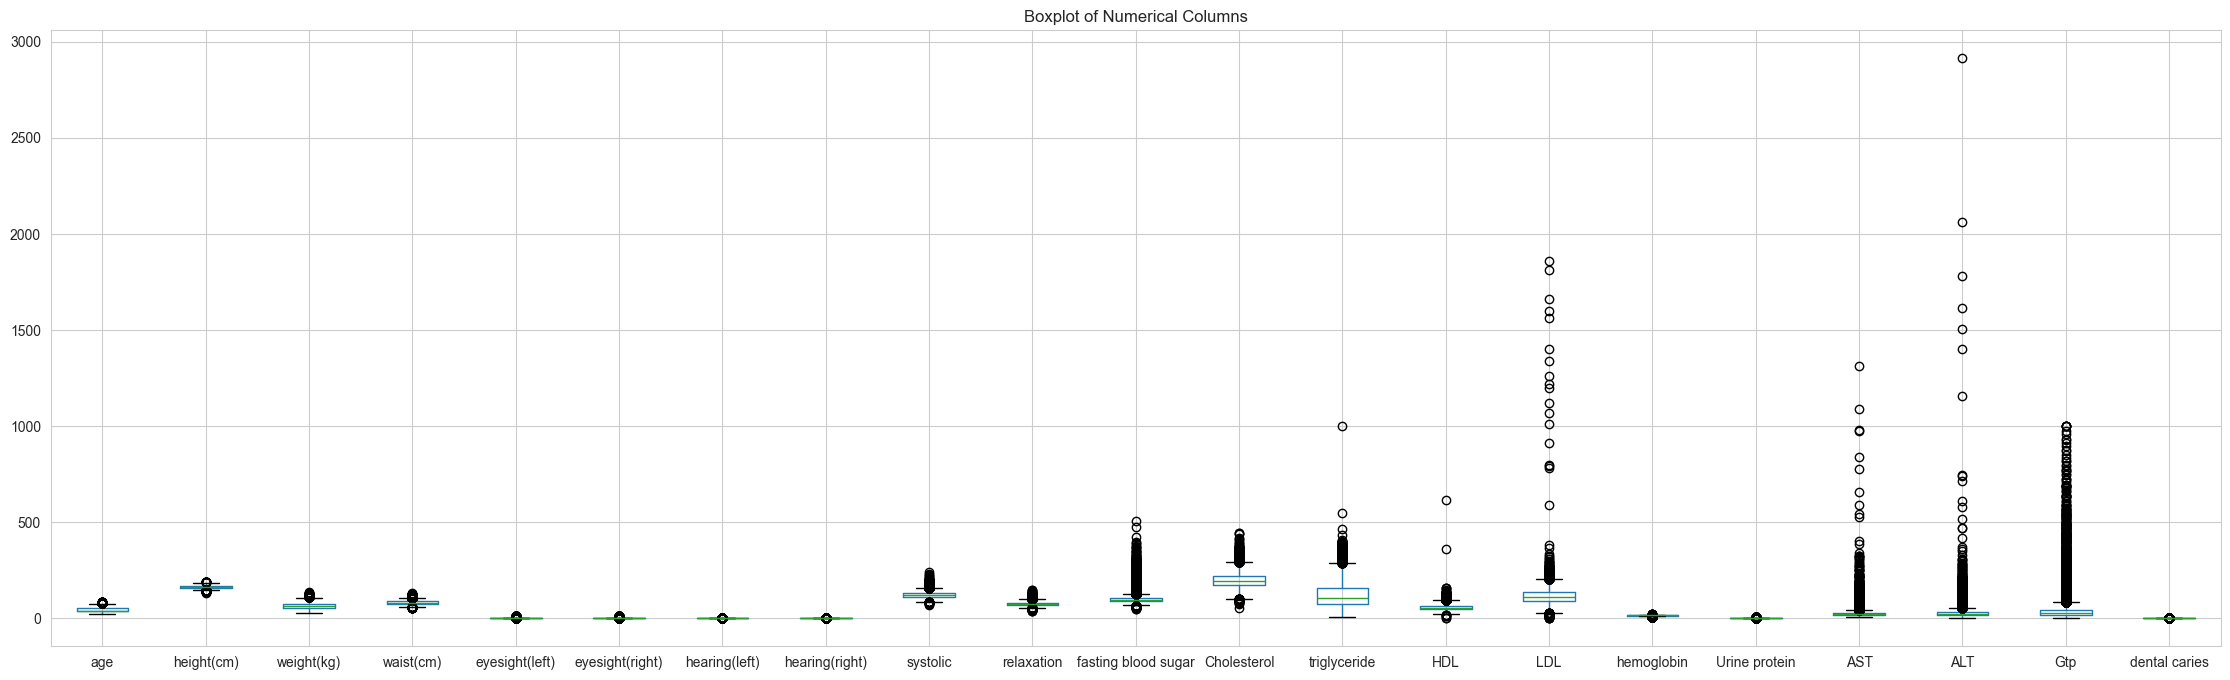

In [135]:
# Specify the columns to plot
numeric_cols = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'AST', 'ALT', 'Gtp', 'dental caries']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(28,8))

# Create the boxplot
df[numeric_cols].boxplot(ax=ax)

# Set the plot title
ax.set_title('Boxplot of Numerical Columns')

# Show the plot
plt.show()

# Plotting each colummns


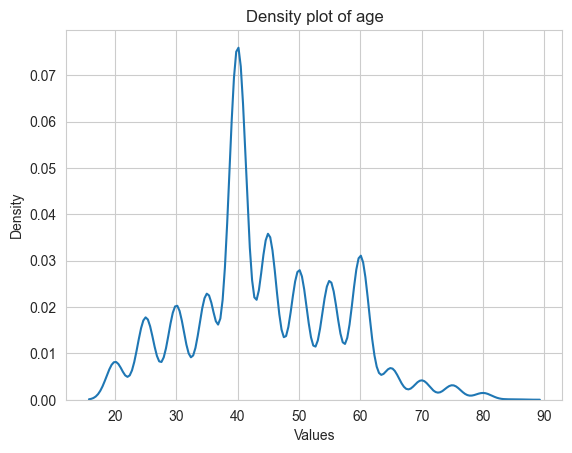

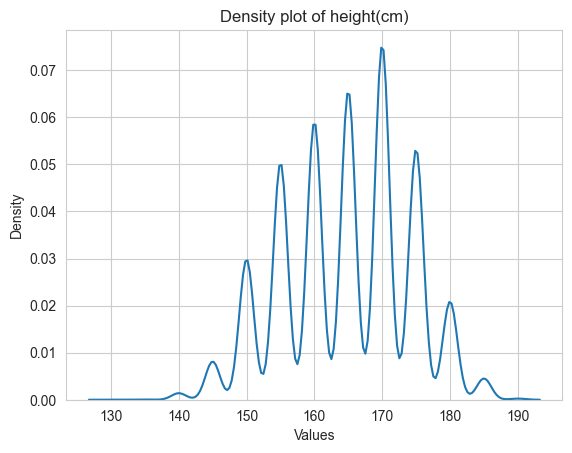

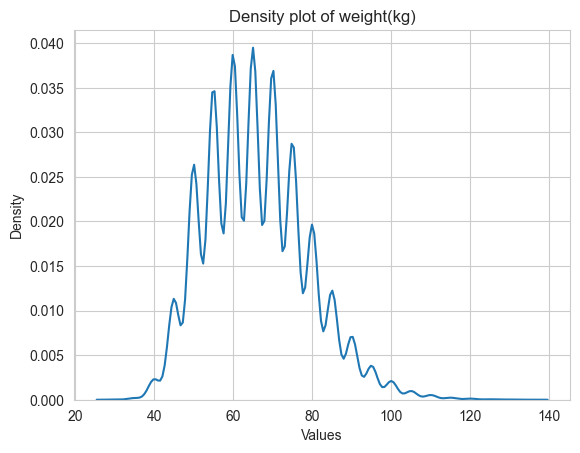

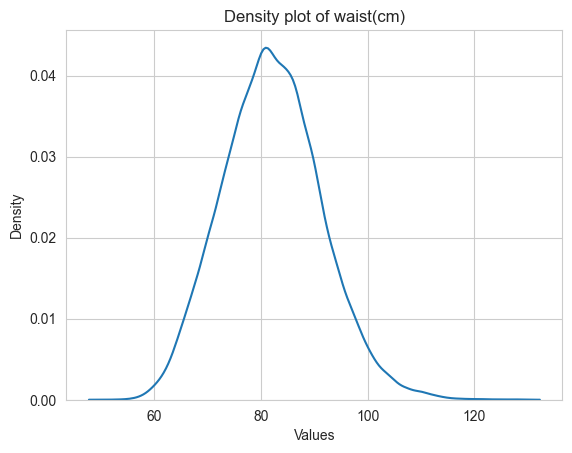

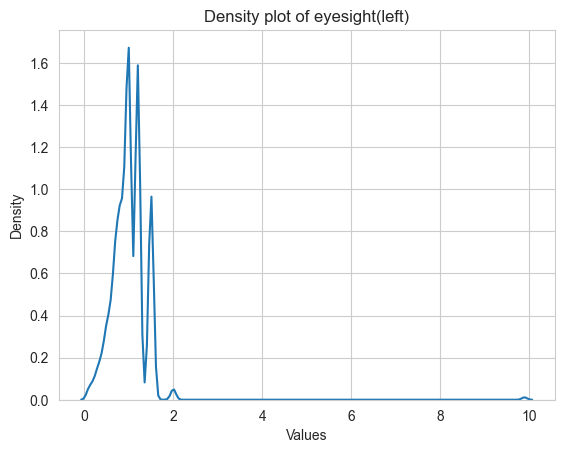

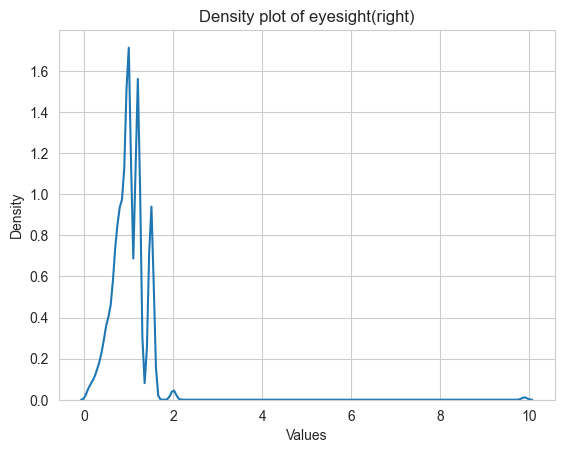

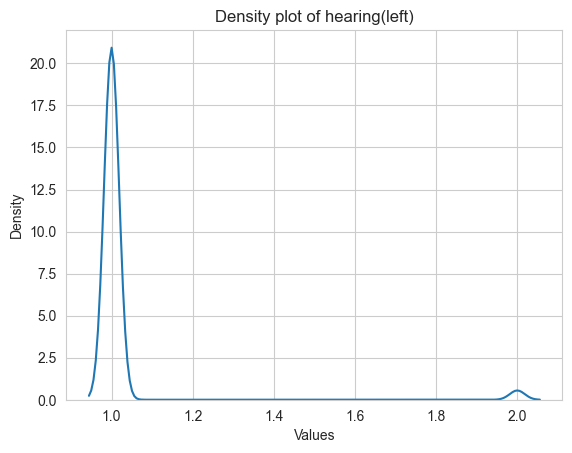

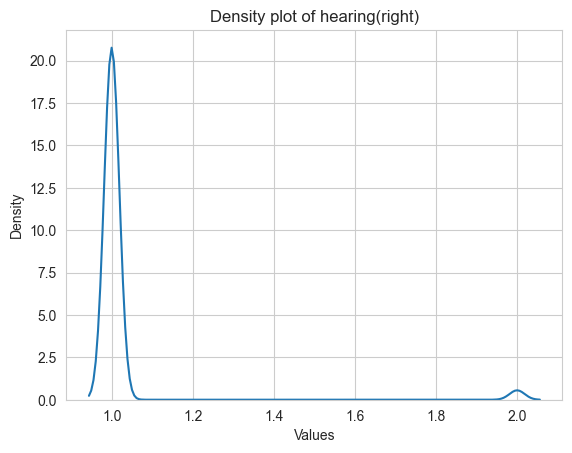

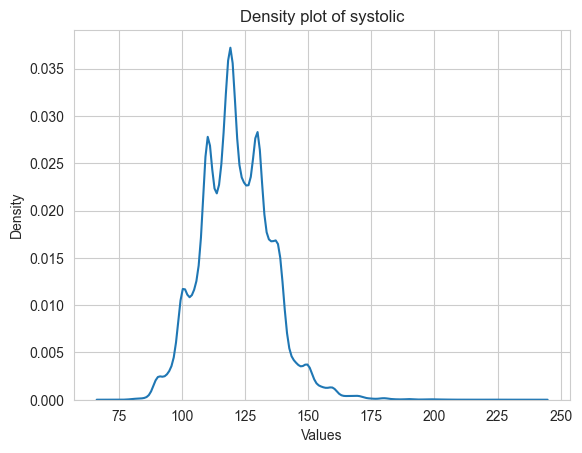

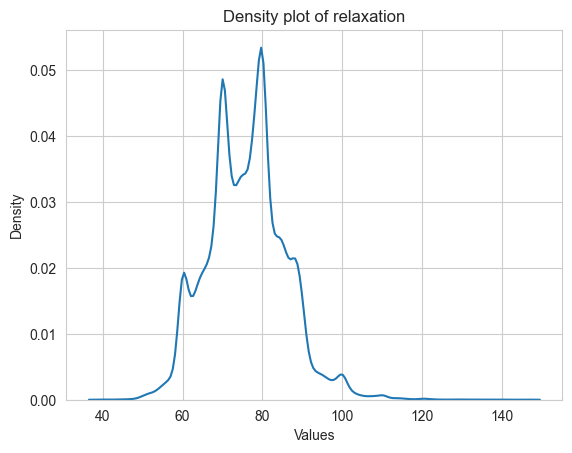

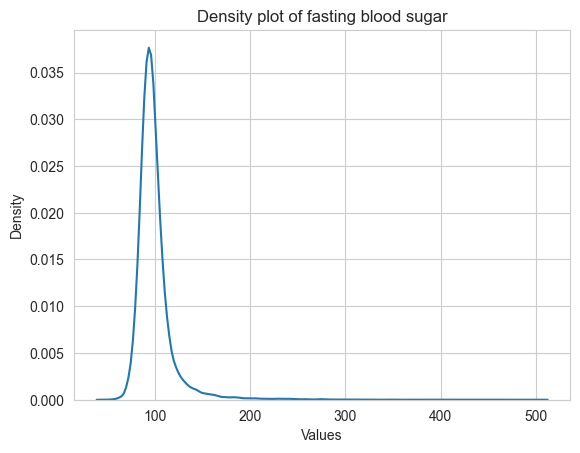

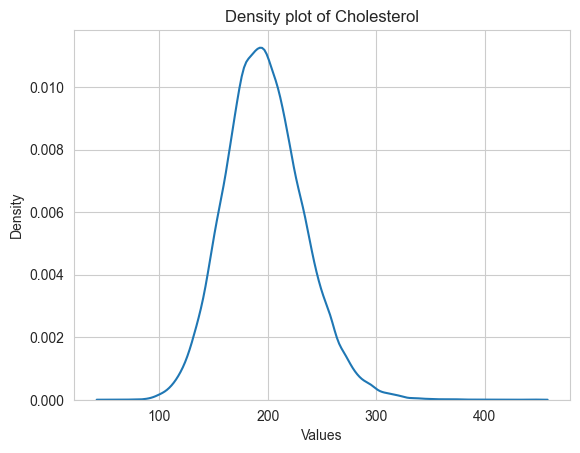

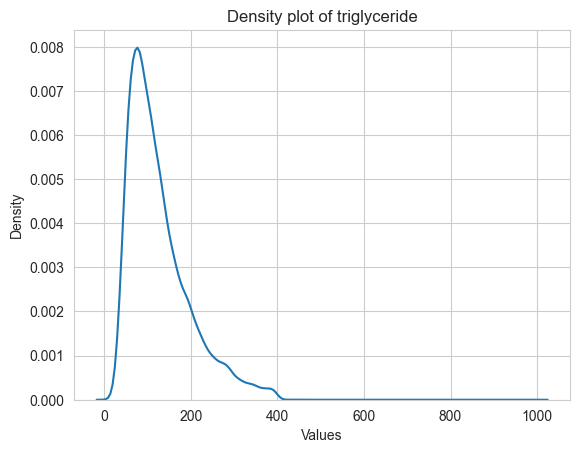

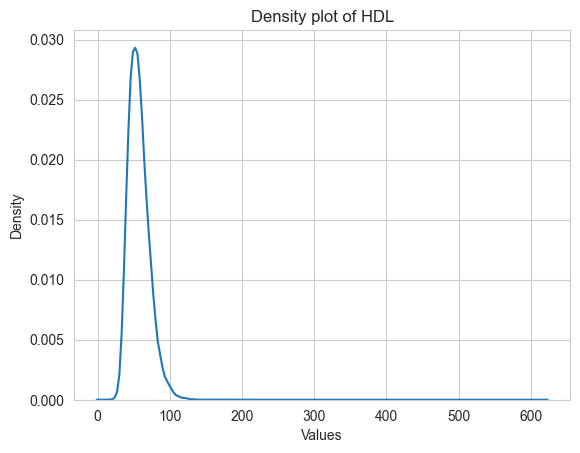

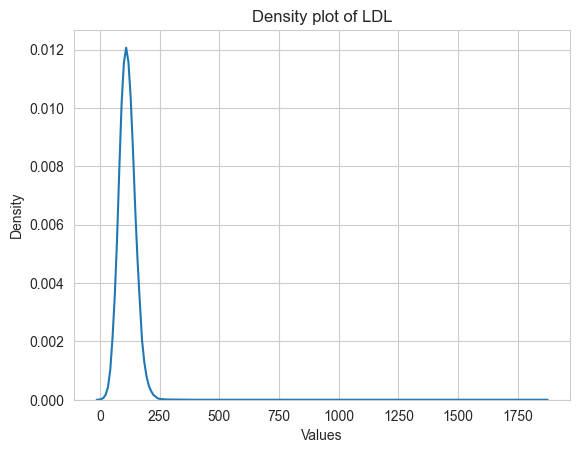

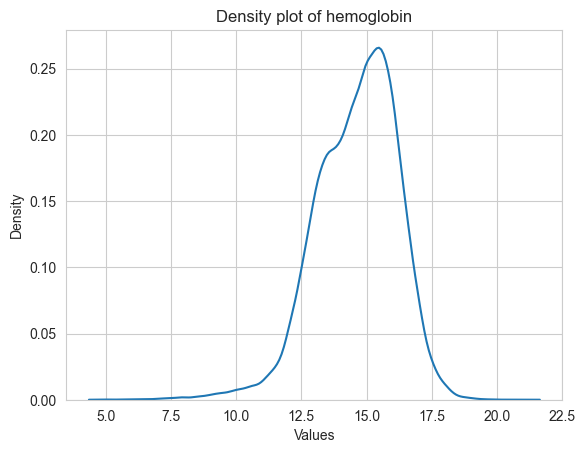

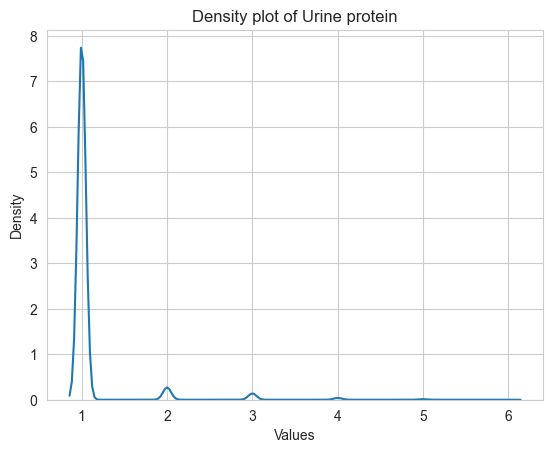

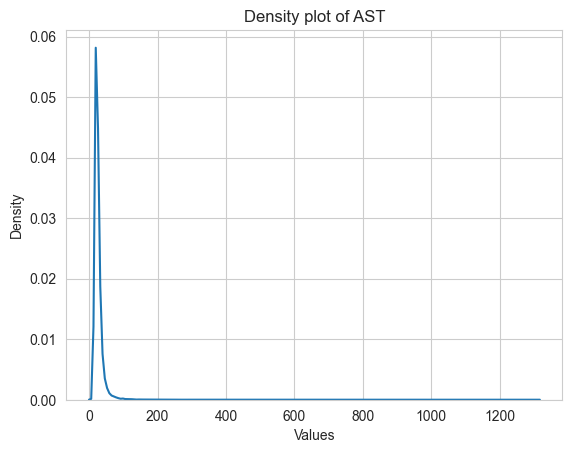

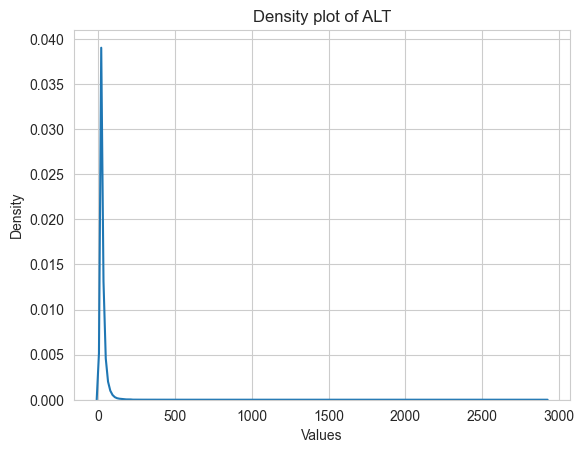

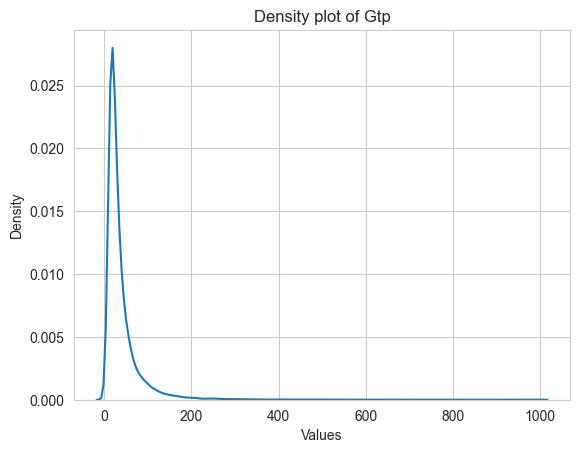

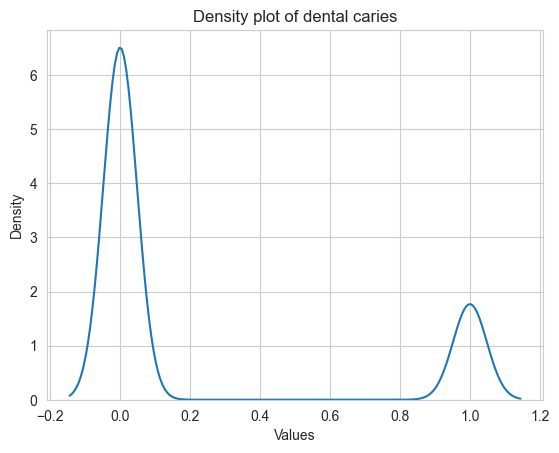

In [136]:
# Loop over each column in the DataFrame
for column_name in numeric_cols:
    
    sns.set_style("whitegrid")
    sns.kdeplot(data=df[column_name])
    plt.xlabel("Values")
    plt.title("Density plot of " + column_name)
    plt.show()

# Division Smoking Not Smoking

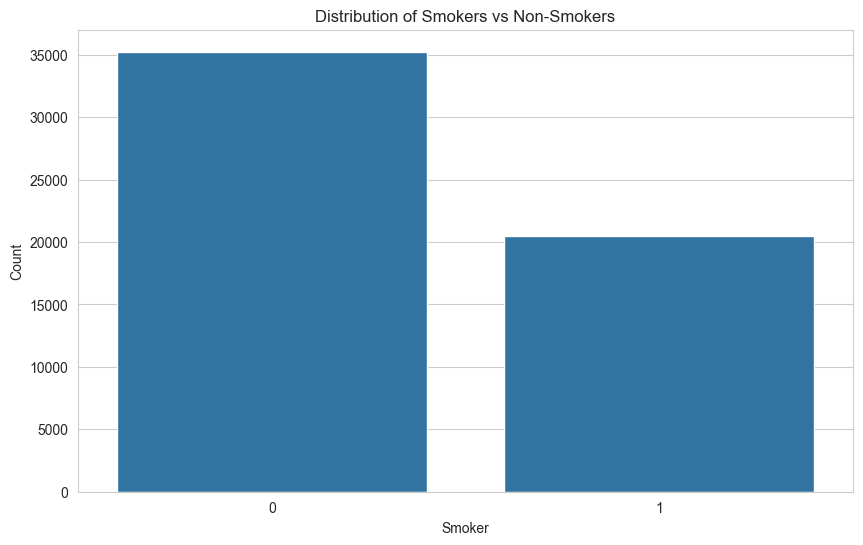

In [137]:
plt.figure(figsize=(10, 6))
sns.countplot(x='smoking', data=data)
plt.title('Distribution of Smokers vs Non-Smokers')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.show()

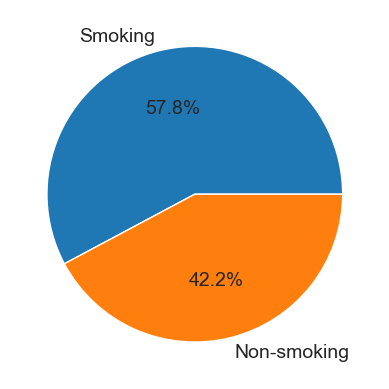

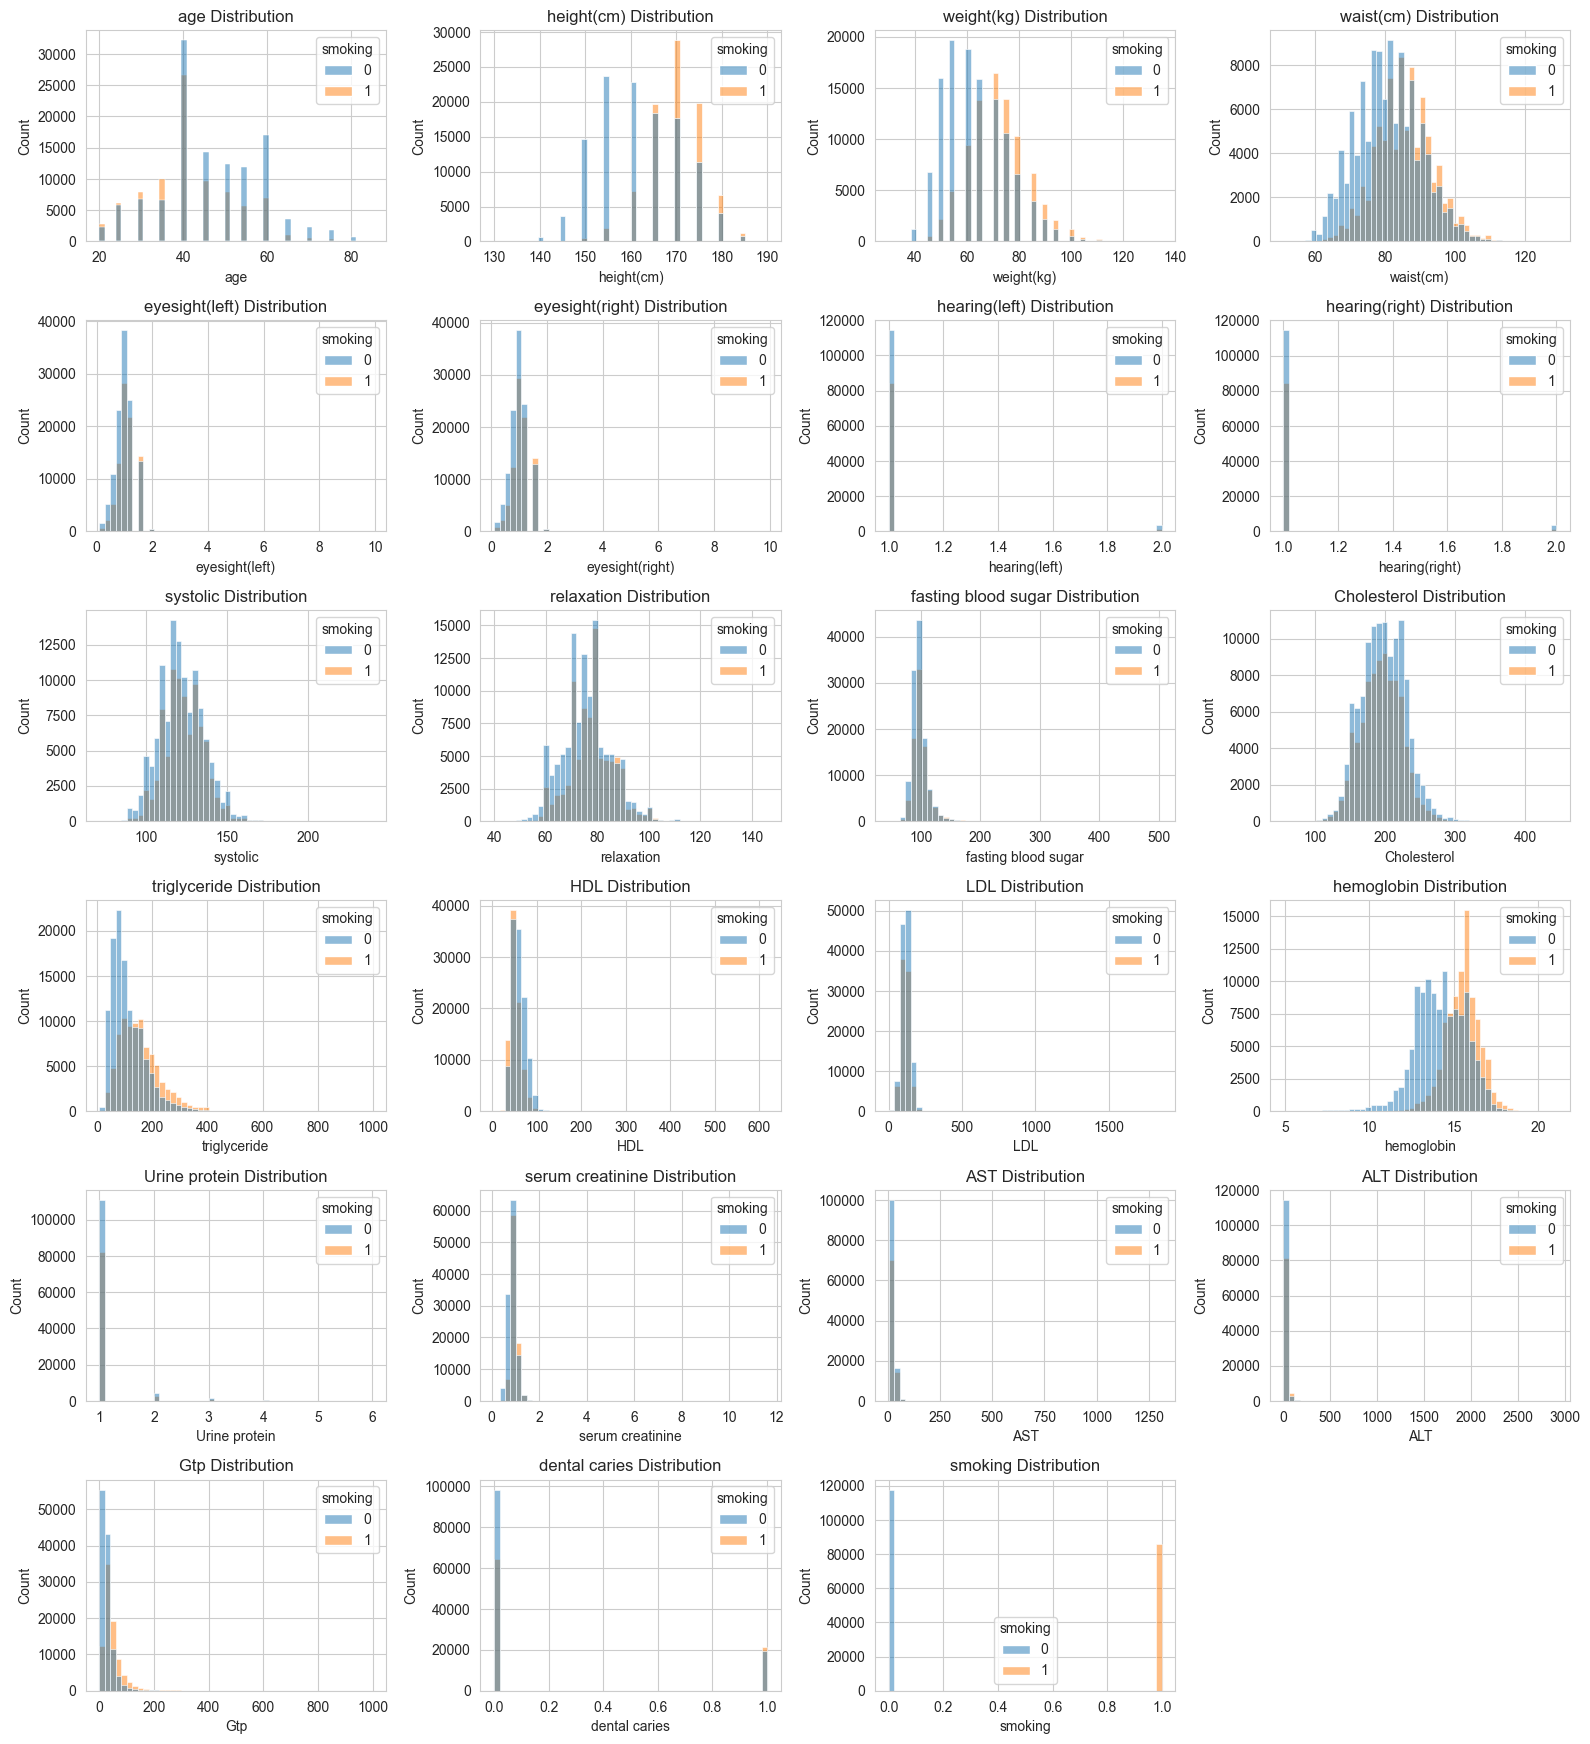

In [138]:
# ----------------------------------------------------------------------------------- #
# visually exploring the distribution of each feature and how it relates
# to the target variable 'smoking'. It helps in identifying potential patterns
# and differences between the two groups.
# ----------------------------------------------------------------------------------- #
plt.pie(df_train['smoking'].value_counts(), labels=['Smoking', 'Non-smoking'], autopct='%1.1f%%', textprops={'fontsize': 14});
num_cols = len(df_train.columns)
plt.figure(figsize=(16, num_cols*1.5))
for i, col in enumerate(df_train.columns):
    plt.subplot(num_cols//2 + num_cols%2, 4, i + 1)
    sns.histplot(x=col, hue='smoking', data=df_train, bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
plt.show()



##### Here we use IQR to detect the outliers and be able to remove them

In [139]:
def detect_outliers(df, min_outlier_occurrences, columns):
    outlier_rows = []
    for col in columns:
        q1 = np.nanpercentile(df[col], 25)
        q3 = np.nanpercentile(df[col], 75)
        iqr = q3 - q1
        outlier_point = 1.5 * iqr
        outliers = df[(df[col] < q1 - outlier_point) | (df[col] > q3 + outlier_point)].index
        outlier_rows.extend(outliers)

    outlier_counts = Counter(outlier_rows)
    outlier_rows_to_drop = [row for row, count in outlier_counts.items() if count >= min_outlier_occurrences]

    return outlier_rows_to_drop


outlier_rows = detect_outliers(df, 5, df.select_dtypes(["float", "int"]).columns)
df = df.drop(outlier_rows)

In [140]:
df.isnull().sum()

gender                 0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
oral                   0
dental caries          0
tartar                 0
smoking                0
dtype: int64

In [141]:
df.shape

(44084, 26)

In [142]:
df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,...,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000,44084.000000
mean,44.178273,164.641026,65.759573,81.962905,1.012676,1.008518,1.023818,1.024295,121.365189,75.934262,...,57.318914,114.960916,14.614207,1.081458,0.885525,25.794370,26.469966,38.736934,0.210507,0.365484
std,12.056772,9.189835,12.681717,9.178336,0.486917,0.481965,0.152484,0.153964,13.499198,9.577142,...,14.748826,40.125841,1.559347,0.388878,0.225551,17.217872,28.486264,46.216111,0.407674,0.481571
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,1.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,47.000000,92.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,25.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,66.000000,136.000000,15.700000,1.000000,1.000000,28.000000,30.000000,43.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,240.000000,140.000000,...,618.000000,1860.000000,20.900000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44084 entries, 0 to 44552
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               44084 non-null  object 
 1   age                  44084 non-null  int64  
 2   height(cm)           44084 non-null  int64  
 3   weight(kg)           44084 non-null  int64  
 4   waist(cm)            44084 non-null  float64
 5   eyesight(left)       44084 non-null  float64
 6   eyesight(right)      44084 non-null  float64
 7   hearing(left)        44084 non-null  float64
 8   hearing(right)       44084 non-null  float64
 9   systolic             44084 non-null  float64
 10  relaxation           44084 non-null  float64
 11  fasting blood sugar  44084 non-null  float64
 12  Cholesterol          44084 non-null  float64
 13  triglyceride         44084 non-null  float64
 14  HDL                  44084 non-null  float64
 15  LDL                  44084 non-null  floa

In [144]:
df.groupby('gender').size().plot(kind='pie', explode=[0,0.1], autopct='%1.1f%%', shadow=True, colors=["pink", "gray"], title="Gender")

<Axes: title={'center': 'Gender'}>

In [145]:
df.groupby('tartar').size().plot(kind='bar', title="Tartar", rot=0, xlabel='Age', ylabel='Count')

<Axes: title={'center': 'Tartar'}, xlabel='Age', ylabel='Count'>

In [146]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))
axes = axes.flatten()

sns.scatterplot(ax = axes[0], x = "relaxation", y = "hemoglobin",
                hue = "smoking", size = "gender", sizes=(20, 100), legend="full",
                data = df).set(title = "Relationship between 'Relaxation' and 'hemoglobin'");

sns.scatterplot(ax = axes[1], x = "systolic", y = "Cholesterol", hue = "smoking",
                size = "gender", sizes=(20, 100), legend="full",
                data = df).set(title = "Relationship between 'Systolic' and 'cholesterol'");

sns.scatterplot(ax = axes[2], x = "LDL", y = "Urine protein", hue = "smoking",
                size = "gender", sizes=(20, 100), legend="full",
                data = df).set(title = "Relationship between 'LDL' and 'urine protein'");

sns.scatterplot(ax = axes[3], x = "HDL", y = "serum creatinine", hue = "smoking",
                size = "gender", sizes=(20, 100), legend="full",
                data = df).set(title = "Relationship between 'HDL' and 'serum creatinine'");

sns.scatterplot(ax = axes[4], x = "weight(kg)", y = "Gtp", hue = "smoking",
                size = "gender", sizes=(20, 100), legend="full",
                data = df).set(title = "Relationship between 'GTP' and 'age'");

sns.scatterplot(ax = axes[5], x = "AST", y = "fasting blood sugar", hue = "smoking",
                size = "gender", sizes=(20, 100), legend="full",
                data = df).set(title = "Relationship between 'AST' and 'fasting blood sugar'");

In [147]:
df.hist(figsize = (20, 20), bins = 12, legend = False);

In [148]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
axes = axes.flatten()

sns.barplot(ax=axes[0],
            x=df["gender"].value_counts().index,
            y=df["gender"].value_counts().values,
            saturation=1).set(title="Frequency of classes of the 'gender' variable")

sns.barplot(ax=axes[1],
            x=df["tartar"].value_counts().index,
            y=df["tartar"].value_counts().values,
            saturation=1).set(title="Frequency of cases of tartar")

sns.barplot(ax=axes[2],
            x=df["dental caries"].value_counts().index,
            y=df["dental caries"].value_counts().values,
            saturation=1).set(title="Frequency of cases of dental caries")

sns.barplot(ax=axes[3],
            x=df["smoking"].value_counts().index,
            y=df["smoking"].value_counts().values,
            saturation=1).set(title="Frequency of classes of the 'smoking' variable")

[Text(0.5, 1.0, "Frequency of classes of the 'smoking' variable")]

In [149]:
fig = px.scatter_3d(df, 
                    x = "hemoglobin",
                    y = "age",
                    z = "Cholesterol",
                    color="smoking")
fig.show();

# DATA PROCESSING

In [150]:
lbe = LabelEncoder()
lbe.fit_transform(df["gender"])
df["gender"] = lbe.fit_transform(df["gender"])
lbe.fit_transform(df["tartar"])
df["tartar"] = lbe.fit_transform(df["tartar"])
lbe.fit_transform(df["oral"])
df["oral"] = lbe.fit_transform(df["oral"])
lbe.fit_transform(df["smoking"])
df["smoking"] = lbe.fit_transform(df["smoking"])

In [151]:
df.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,12.9,1.0,0.7,18.0,19.0,27.0,0,0,1,0
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,12.7,1.0,0.6,22.0,19.0,18.0,0,0,1,0
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,15.8,1.0,1.0,21.0,16.0,22.0,0,0,0,1
3,1,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,...,14.7,1.0,1.0,19.0,26.0,18.0,0,0,1,0
4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0,0


In [152]:
# select dependent variable (label)
y = df["smoking"]

# select independent variable (estimator)
x = df.drop("smoking", axis = 1)

In [153]:
# Train-Test-Split   
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, shuffle = True, random_state=1)

# Data Scalling

In [154]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Clasisfication Models

## Support Vector Machine (SVM) Model 

In [155]:
svm = SVC(kernel='rbf')
# fit the model with data
svm.fit(x_train, y_train)
# predict with test dataset
y_predict_SVM = svm.predict(x_test)
print(classification_report(y_test,y_predict_SVM))
accuracy_Score_SVM = metrics.accuracy_score(y_test, y_predict_SVM)
print('SVM model accuracy is: {:.2f}%'.format(accuracy_Score_SVM*100))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      5554
           1       0.67      0.70      0.68      3263

    accuracy                           0.76      8817
   macro avg       0.74      0.75      0.74      8817
weighted avg       0.76      0.76      0.76      8817

SVM model accuracy is: 75.83%


### Confusion Matrix for SVM

Confusion Matrix for SVM :
 [[4416 1138]
 [ 993 2270]] 



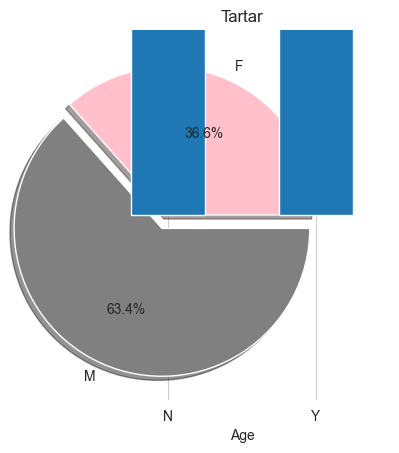

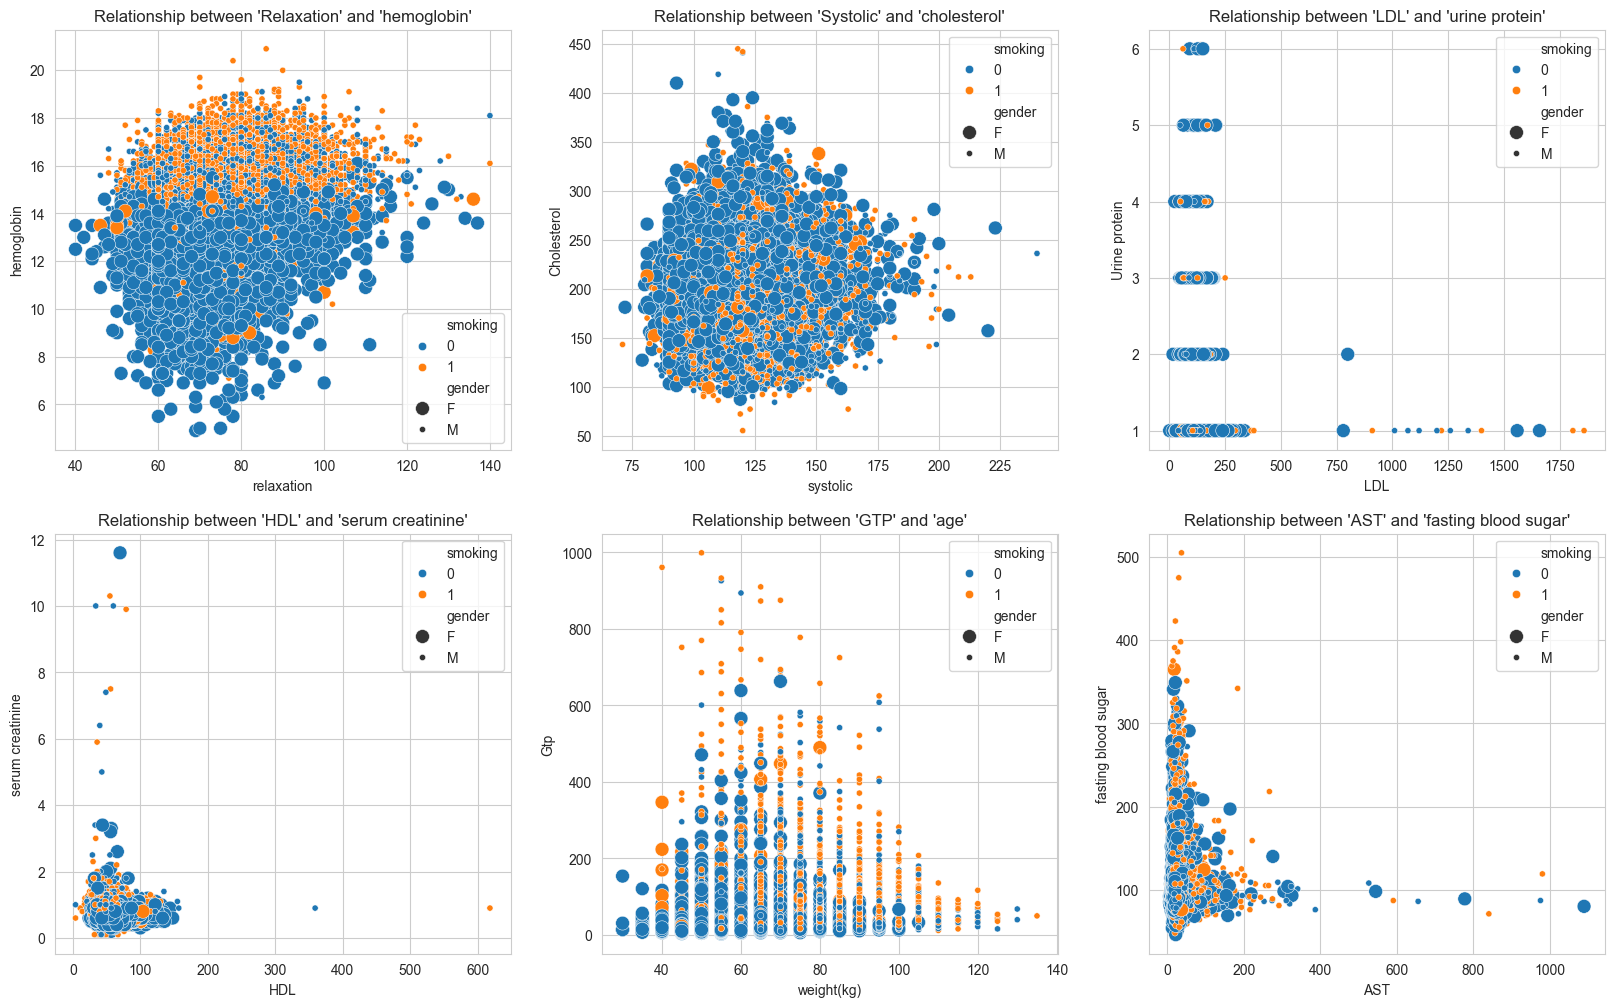

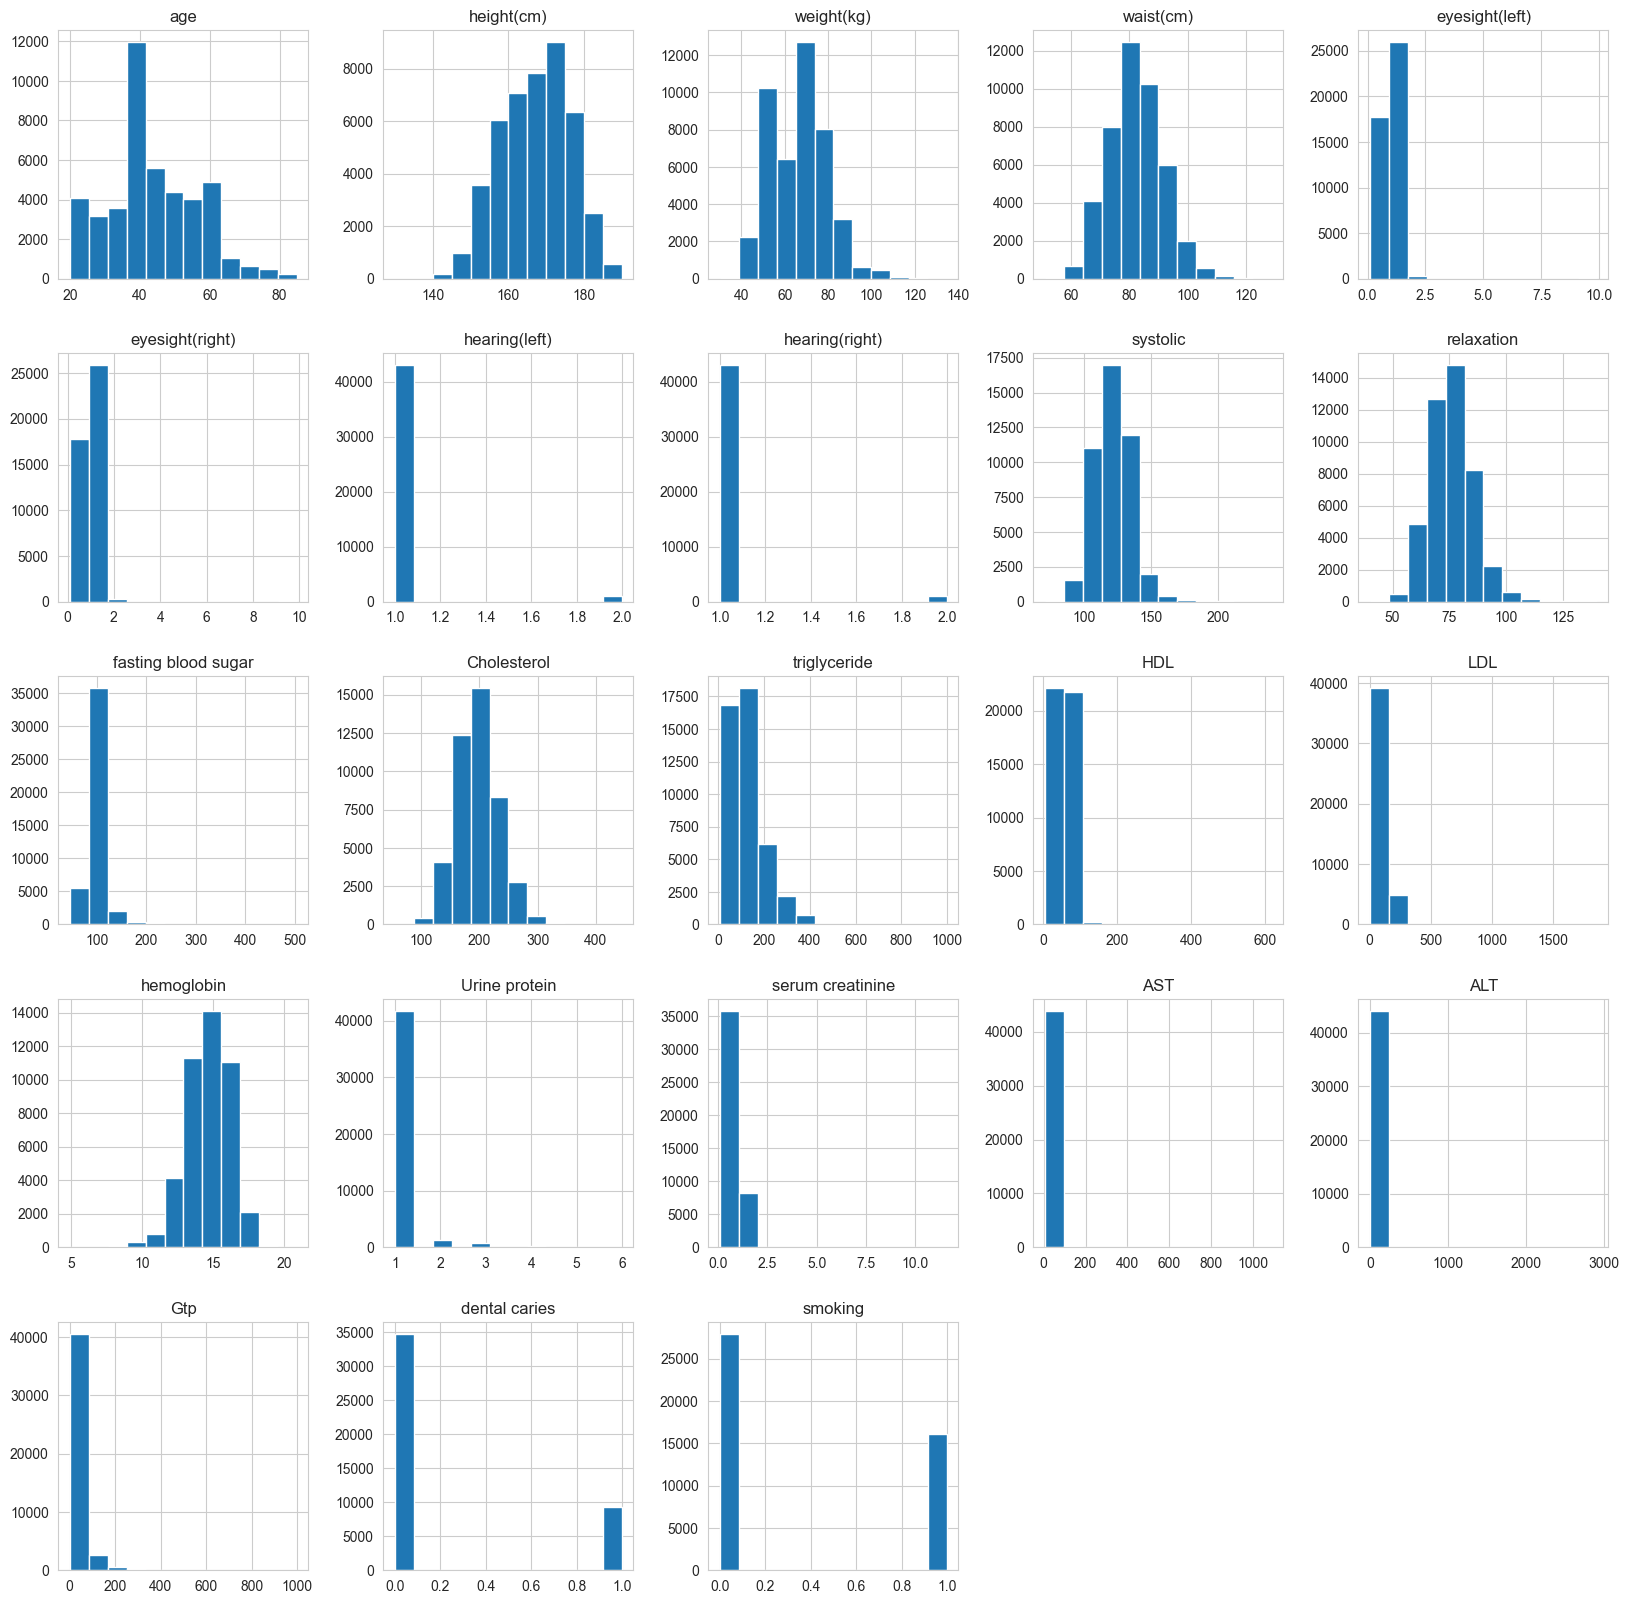

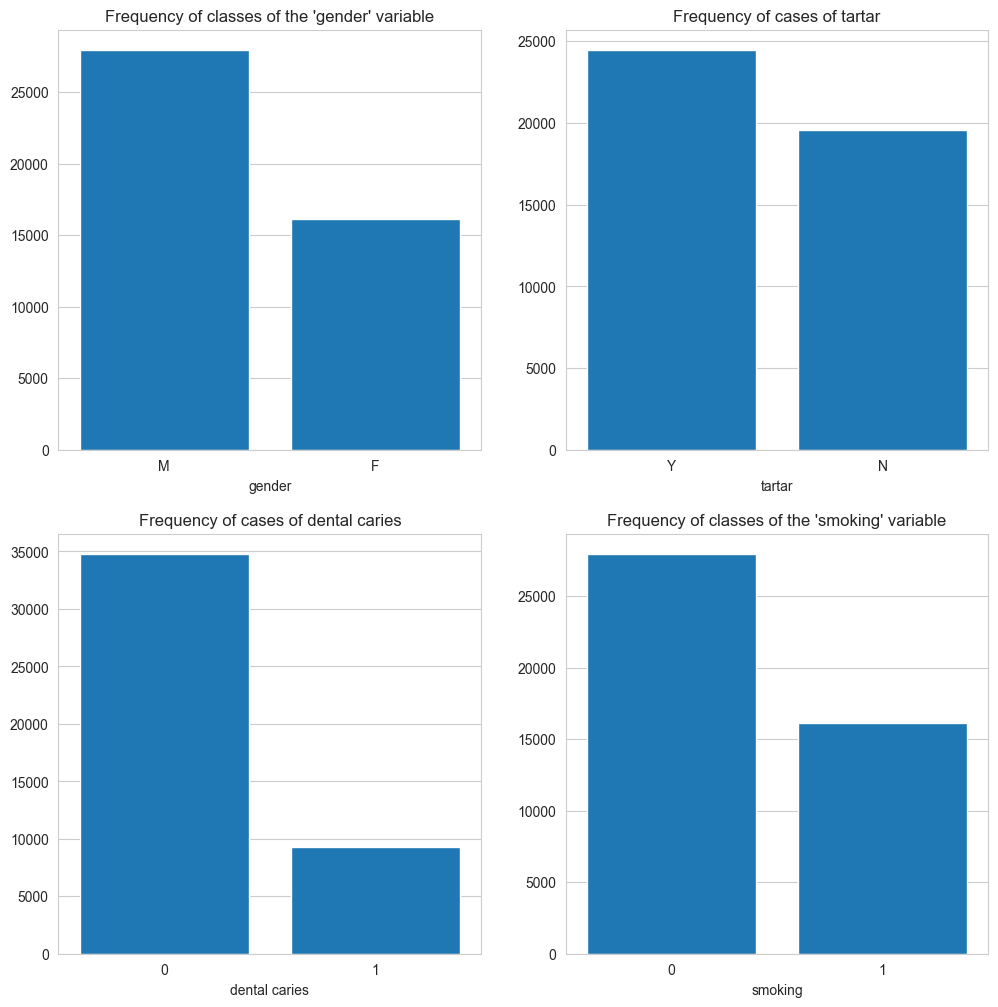

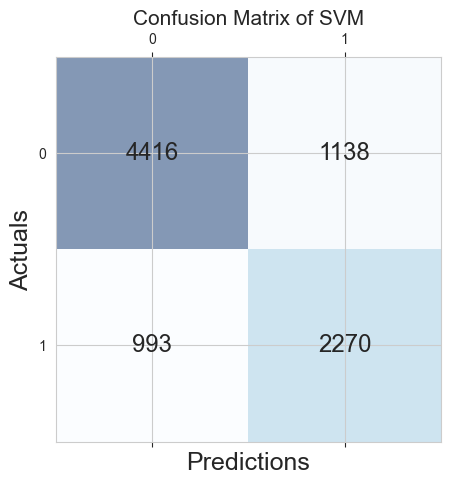

In [156]:
cm = metrics.confusion_matrix(y_test, y_predict_SVM)
print('Confusion Matrix for SVM :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of SVM', fontsize=15)
plt.show()

## Random Forest Classifier  Model 

In [157]:
models = RandomForestClassifier(n_estimators=500)
models.fit(x_train, y_train)
# predict with test dataset
y_predict_random = models.predict(x_test)
print(classification_report(y_test,y_predict_random))
accuracy_Score_random = metrics.accuracy_score(y_test, y_predict_random)
print('RandomForest model accuracy is: {:.2f}%'.format(accuracy_Score_random*100))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      5554
           1       0.67      0.69      0.68      3263

    accuracy                           0.76      8817
   macro avg       0.74      0.75      0.74      8817
weighted avg       0.76      0.76      0.76      8817

RandomForest model accuracy is: 75.89%


### Confusion Matrix for Random Forest Classifier

Confusion Matrix for Random Forest Classifier :
 [[4424 1130]
 [ 996 2267]] 



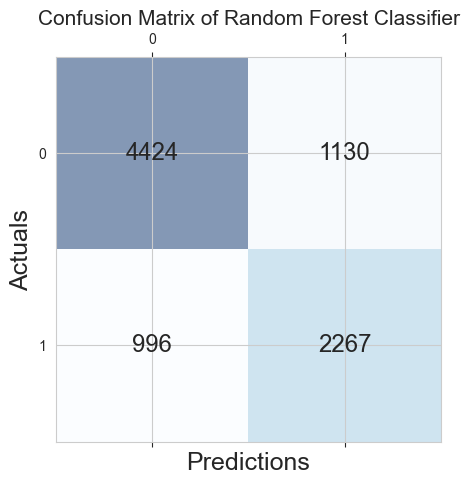

In [158]:
cm = metrics.confusion_matrix(y_test, y_predict_random)
print('Confusion Matrix for Random Forest Classifier :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Random Forest Classifier', fontsize=15)
plt.show()

### XGBoost model

In [159]:
xgb_model = XGBClassifier(n_estimators = 600)
xgb_model.fit(x_train, y_train)
pred_xgb = xgb_model.predict(x_test)
print(classification_report(y_test,pred_xgb))
accuracy_Score_xgb = metrics.accuracy_score(y_test, pred_xgb)
print('XGBoosting model accuracy is: {:.2f}%'.format(accuracy_Score_xgb*100))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      5554
           1       0.66      0.64      0.65      3263

    accuracy                           0.74      8817
   macro avg       0.72      0.72      0.72      8817
weighted avg       0.74      0.74      0.74      8817

XGBoosting model accuracy is: 74.35%


### Confusion Matrix for XGBoost model

Confusion Matrix for XGBoosting Classifier :
 [[4456 1098]
 [1164 2099]] 



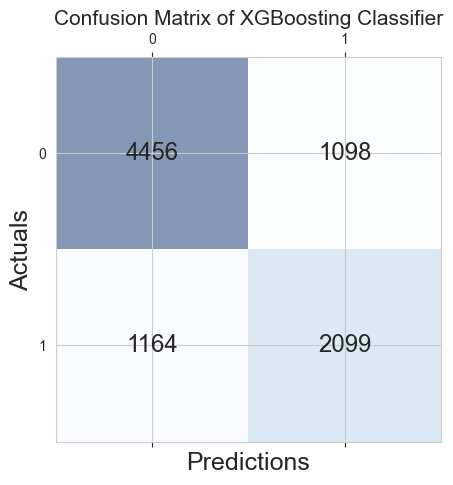

In [160]:
cm = metrics.confusion_matrix(y_test, pred_xgb)
print('Confusion Matrix for XGBoosting Classifier :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of XGBoosting Classifier', fontsize=15)
plt.show()

### Logistic Regression

In [161]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

def fit_model_with_skf(x_train, y_train, model, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    scores = []
    for train_idx, val_idx in skf.split(x_train, y_train):
        X_tr, X_val = x_train[train_idx], x_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    return [mean_score, std_score]

SEED = 42  # Set a random seed for reproducibility

C_list = [0.001, 0.01, 0.1, 1, 10]
overall_scores = []
for C in C_list:
    print(f'Trying C={C}')
    model = LogisticRegression(solver='lbfgs', C=C, random_state=SEED, max_iter=1000)
    fold_score = fit_model_with_skf(x_train, y_train, model)
    fold_score.append(C)
    overall_scores.append(fold_score)

Trying C=0.001
Trying C=0.01
Trying C=0.1
Trying C=1
Trying C=10


In [162]:
for mean, std, C in overall_scores:
    print(f'C={C: <5} mean: {mean:.4f}, std: +- {std:.4f}')

C=0.001 mean: 0.7368, std: +- 0.0049
C=0.01  mean: 0.7444, std: +- 0.0063
C=0.1   mean: 0.7448, std: +- 0.0052
C=1     mean: 0.7447, std: +- 0.0050
C=10    mean: 0.7447, std: +- 0.0049


In [163]:
log_reg_final = LogisticRegression(solver='lbfgs', C=1, random_state=SEED, max_iter=1000)

### Confussion Matrix for Logistic Regression

In [164]:
cm = metrics.confusion_matrix(y_test, pred_xgb)
print('Confusion Matrix for Logistic Regression :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

Confusion Matrix for Logistic Regression :
 [[4456 1098]
 [1164 2099]] 



### ROC Curve

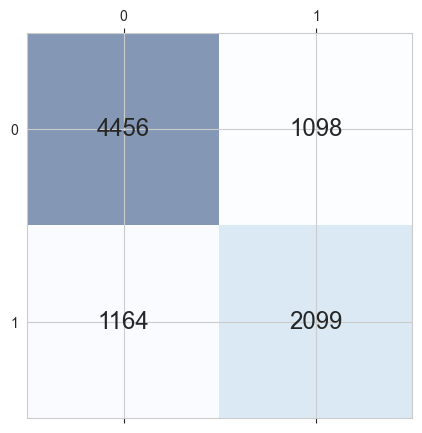

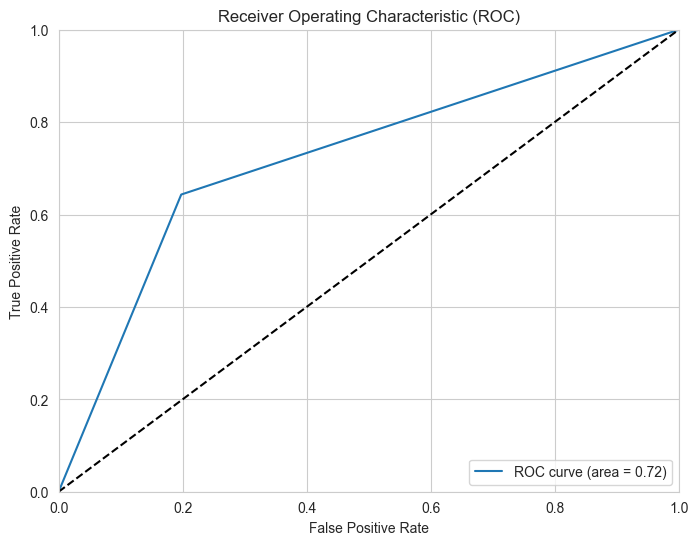

In [165]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, pred_xgb)
auc = roc_auc_score(y_test, pred_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

gender: 0.7654139995574951
dental caries: 0.015910226851701736
age: 0.014682786539196968
Gtp: 0.01460484229028225
tartar: 0.013816277496516705
hearing(right): 0.011419878341257572
serum creatinine: 0.010816616006195545
Urine protein: 0.010239744558930397
triglyceride: 0.010000566951930523
ALT: 0.009948305785655975
height(cm): 0.009817388840019703
weight(kg): 0.009631941094994545
hemoglobin: 0.00954386219382286
LDL: 0.009482072666287422
waist(cm): 0.009206365793943405
AST: 0.009105001576244831
HDL: 0.009099720045924187
systolic: 0.009030166082084179
fasting blood sugar: 0.008909855969250202
Cholesterol: 0.008623886853456497
eyesight(left): 0.008615872822701931
relaxation: 0.008462068624794483
eyesight(right): 0.008456396870315075
hearing(left): 0.005162142217159271
oral: 0.0


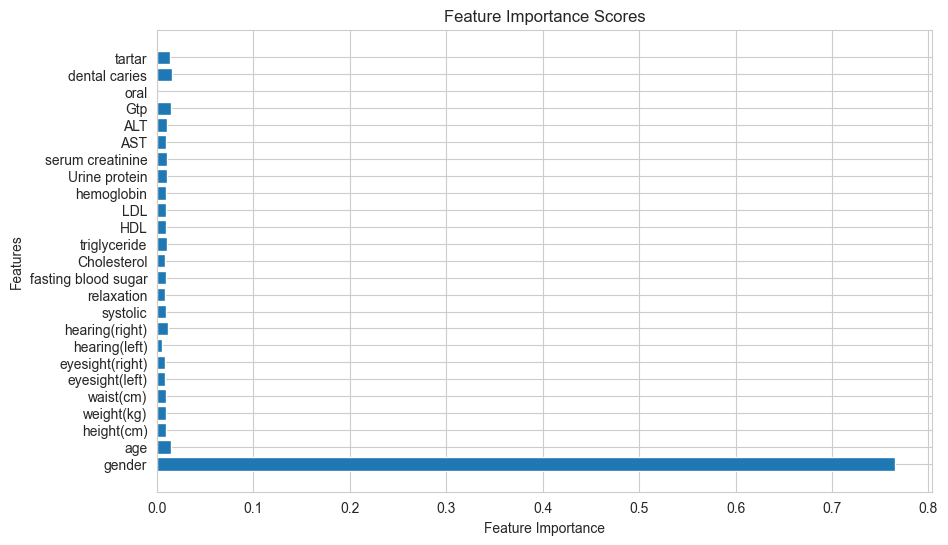

In [166]:
# Get the feature importance scores
importance_scores = xgb_model.feature_importances_

# Get the names of the features
feature_names = x.columns

# Create a dictionary with feature names as keys and importance scores as values
feature_importance = dict(zip(feature_names, importance_scores))

# Sort the features based on their importance scores
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance in descending order
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_scores)), importance_scores, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.show()

In [167]:
# Fit the logistic regression model before using it for prediction
log_reg_final.fit(x_train, y_train)

x = PrettyTable()
print('\n')
print("Comparison of Models Results")
x.field_names = ["Model", "Accuracy"]

x.add_row(["Random Forest", round(accuracy_score(y_test, models.predict(x_test)), 3)])
x.add_row(["SVM", round(accuracy_score(y_test, svm.predict(x_test)), 3)])
x.add_row(["XGBoost", round(accuracy_score(y_test, xgb_model.predict(x_test)), 2)])
x.add_row(["Logistic Regression", round(accuracy_score(y_test, log_reg_final.predict(x_test)), 2)])

print(x)
print('\n')



Comparison of Models Results
+---------------------+----------+
|        Model        | Accuracy |
+---------------------+----------+
|    Random Forest    |  0.759   |
|         SVM         |  0.758   |
|       XGBoost       |   0.74   |
| Logistic Regression |   0.75   |
+---------------------+----------+


